# TP1: Análisis Básico

Doce atletas entrenan para una competencia de 100m llanos. El entrenamiento se realiza aún en condiciones climáticas adversas. El archivo tiempos.txt contiene los tiempos en segundos de cada atleta para un entrenamiento en un dí0a soleado, en un día nublado y en un día de lluvia intensa.

Utilizando el lenguaje Python, procedimos a analizar los datos. Como primer paso, importamos los paquetes a utilizar.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [31]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## 1. Datos

Cargamos los datos y los visualizamos.

In [4]:
# Atleta tiempo_sol tiempo_nublado tiempo_lluvia
datos = np.loadtxt('tiempos.txt', skiprows=1)

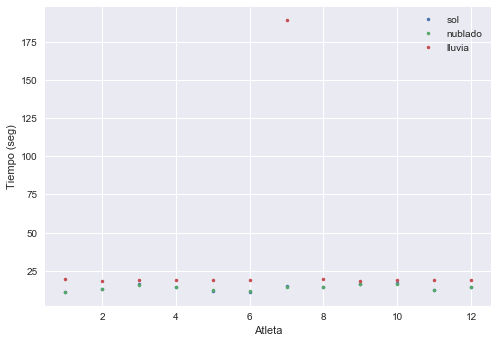

In [5]:
plt.plot(datos[:,0], datos[:,1], '.', label='sol')
plt.plot(datos[:,0], datos[:,2], '.', label='nublado')
plt.plot(datos[:,0], datos[:,3], '.', label='lluvia')
plt.xlabel('Atleta')
plt.ylabel('Tiempo (seg)')
plt.legend()
plt.show()

En lluvia tenemos un outlier. Vemos que parecería ser porque faltó el punto decimal. Lo agregamos.

In [6]:
datos[6, 3] = datos[6, 3] / 10.

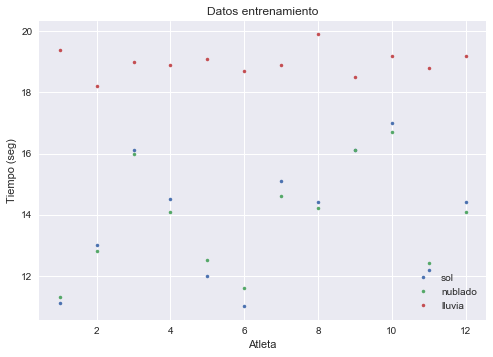

In [7]:
plt.plot(datos[:,0], datos[:,1], '.', label='sol')
plt.plot(datos[:,0], datos[:,2], '.', label='nublado')
plt.plot(datos[:,0], datos[:,3], '.', label='lluvia')
plt.xlabel('Atleta')
plt.ylabel('Tiempo (seg)')
plt.title('Datos entrenamiento')
plt.legend()

In [8]:
sol, nublado, lluvia = datos[:,1], datos[:, 2], datos[:, 3]

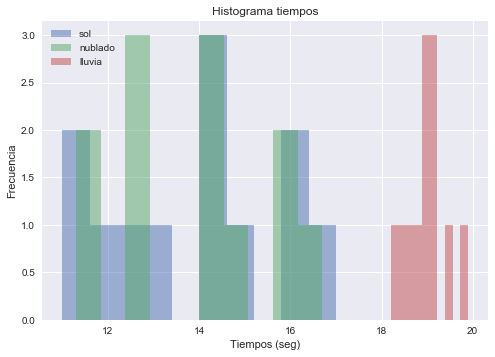

In [9]:
plt.hist(sol, alpha=0.5, label='sol')
plt.hist(nublado, alpha=0.5, label='nublado')
plt.hist(lluvia, alpha=0.5, label='lluvia')
plt.title('Histograma tiempos')
plt.xlabel('Tiempos (seg)')
plt.ylabel('Frecuencia')
plt.legend()

In [10]:
plt.show()

## 2. Tests

Aplicamos distintos test sobre los datos para evaluar diferentes hipótesis sobre los datos.

### 2.1. Los atletas son más lentos en días de lluvia que en días soleados.

#### Vemos correlación en las velocidades de los atletas en sol y en lluvia.

In [11]:
r, p = sp.stats.pearsonr(sol, lluvia)
'rho = {:.2f}, p = {}'.format(r, p)

'rho = 0.05, p = 0.871057017179'

No hay correlación entre los datos. Ambos conjuntos de datos tienen comportamientos distintos.

#### Vemos correlación en las velocidades de los atletas en sol y en nublado.

In [12]:
r, p = sp.stats.pearsonr(sol, nublado)
'rho = {:.2f}, p = {}'.format(r, p)

'rho = 0.99, p = 5.04564639981e-10'

Vemos que hay una relación en las velocidades de los atletas en los días soleados y nublados.

#### Queremos descartar que los atletas son igual de rápidos en días soleados y en días de lluvia.

h_0 : los tiempos de los atletas en días de lluvia es el mismo que en días soleados.

In [13]:
sp.stats.ttest_rel(lluvia, sol)

Ttest_relResult(statistic=8.576227572594302, pvalue=3.3516511607218045e-06)

Podemos descartar que los atletas tengan los mismos tiempos en ambos climas.

El estadístico indicaría que el tiempo en lluvia es mayor. 


    Tema de hipótesis: ¿Se cumplen o hay que verificarlas?
    
        - Variables distribuídas normalmente
        - Igual varianza
        - Muestras independientes

#### Hacemos un test de permutaciones.

In [14]:
todos =  np.concatenate((sol, lluvia))
etiquetas_sol = np.repeat('sol', sol.size)
etiquetas_lluvia = np.repeat('lluvia', lluvia.size)
etiquetas = np.concatenate((etiquetas_sol, etiquetas_lluvia))

Todos los valores con respectivas etiquetas.

In [37]:
print('Todos los valores con respectivas etiquetas.')
pd.DataFrame({'valores': todos, 'etiquetas':etiquetas}).T

Todos los valores con respectivas etiquetas.


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
etiquetas,lluvia,lluvia,sol,sol,sol,sol,sol,sol,sol,sol,...,lluvia,lluvia,lluvia,lluvia,lluvia,sol,lluvia,lluvia,sol,lluvia
valores,11.1,13,16.1,14.5,12,11,15.1,14.4,16.1,17,...,19,18.9,19.1,18.7,18.9,19.9,18.5,19.2,18.8,19.2


In [40]:
delta_0 = lluvia.mean() - sol.mean()
print('Diferencia de promedios entre lluvia y sol: {:.4f} seg'.format(delta_0))

Diferencia de promedios entre lluvia y sol: 5.0750 seg


Calculamos distribución con permutaciones.

In [17]:
deltas = []
for i in range(1000):
    etiquetas_s = np.copy(etiquetas)
    np.random.shuffle(etiquetas)
    sol_s = todos[etiquetas_s == 'sol']
    lluvia_s = todos[etiquetas_s == 'lluvia']
    delta_1 = lluvia_s.mean() - sol_s.mean()
    deltas.append(delta_1)

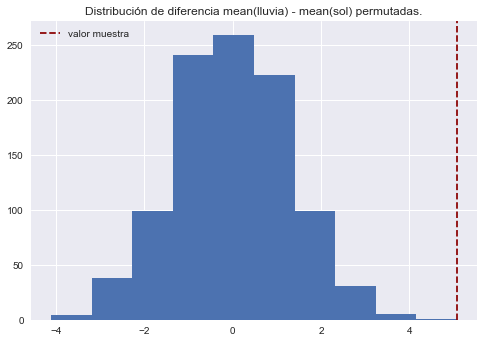

In [49]:
plt.hist(deltas)
plt.axvline(delta_0, color='darkred', linestyle='--', label='valor muestra')
plt.title(u'Distribución de diferencia mean(lluvia) - mean(sol) permutadas.')
plt.legend()

In [19]:
deltas = np.array(deltas)

In [52]:
p = np.sum(deltas > delta_0) / 1000.
print('Probabilidad de el valor de la muestra en la distribución de permutaciones: {:.2f}'.format(p))

Probabilidad de el valor de la muestra en la distribución de permutaciones: 0.00


    ¿Podemos concluir de acá que además la diferencia es positiva? ¿Esto es, que en lluvia son más lentos?

### 2.2. El cielo nublado no influye en los tiempos de los atletas.
#### Hago dos tests de muestras apareadas

h0_sol = los dias nublados influyen de la misma manera que los dias soleados en el tiempo de los atletas

In [21]:
sp.stats.ttest_rel(nublado, sol)

Ttest_relResult(statistic=-0.41213824986058739, pvalue=0.68815561156045579)

Debido a que se encontro un p-value de 0.688, no se puede descartar la hipotesis sugerida. El resultado del estadistico indicaria que en los dias nublados, los atletas logran tiempos menores.

h0_lluvia = los dias nublados influyen de la misma manera que los dias lluviosos en el tiempo de los atletas

In [22]:
sp.stats.ttest_rel(nublado, lluvia)

Ttest_relResult(statistic=-9.7201289951570811, pvalue=9.8103994928779318e-07)

Podemos descartar la hipotesis que los dias nublados influyen de igual modo que los lluviosos basandonos en el p-value obtenido. Es decir, la probabilidad de que los dias nublado interfieran de la misma manera que los dias con lluvia es muy baja. Pareceria que, al igual que en el test con los dias soleados, en los dias nublados, los atletas logran tiempos menores.

Comparando los resultados de ambos tests de muestras apareadas, se observa una clara diferencia entre la performance de los atletas entre los dias nublados y de lluvia. No puede decirse lo mismo respecto a los dias soleados y nublados.

#### Test ANOVA para las tres muestras
Quiero un test que me permita comparar los tres climas, para ver si entre ellos hay alguna diferencia.

In [23]:
t, p = sp.stats.f_oneway(nublado, lluvia, sol)
't = {:.2f}, p = {}'.format(t, p)

't = 41.57, p = 9.6112634512e-10'

Una muestra difiere del resto debido el valor pequenio de p. Tengo que saber que tipo de clima es el que causa esa diferencia. 
#### Hago ANOVA de a pares.

ANOVA nublado-sol: ambos climas influyen de la misma manera sobre los atletas.

In [24]:
t_1, p_1 = sp.stats.f_oneway(nublado, sol)
't_1 = {:.4f}, p_1 = {}'.format(t_1, p_1)

't_1 = 0.0029, p_1 = 0.957892655613'

ANOVA nublado-lluvia: ambos climas influyen de la misma manera sobre los atletas.

In [25]:
t_2, p_2 = sp.stats.f_oneway(nublado, lluvia)
't_2 = {:.2f}, p_2 = {}'.format(t_2, p_2)

't_2 = 92.64, p_2 = 2.40875774137e-09'

ANOVA lluvia-sol: ambos climas influyen de la misma manera sobre los atletas.

In [26]:
t_3, p_3 = sp.stats.f_oneway(lluvia, sol)
't_3 = {:.2f}, p_3 = {}'.format(t_3, p_3)

't_3 = 71.96, p_3 = 2.20135981111e-08'

Estudiando los valores de p obtenidos, se acepta la primer hipotesis (dias nublados y de sol influyen de igual modo). Y se descartan aquellas dos en las que se afirma los dias nublados y lluviosos y por otro lado soleados y lluviosos influyen de la misma manera sobre los atletas. El clima que provoca performances diferentes sobre los corredores es el lluvioso.

_ Conclusiones: considerando los tests realizados, no se puede concluir que los dias nublados no influyen en la performance de los corredores. Por el contrario, se observa que dicho clima influye de igual modo que los dias soleados, con el agregado de informacion (proveniente de los tests de muestras apareadas) que los atletas podrian lograr tiempos menores en dias nublados. _

### 2.3. El clima influye en la velocidad de los atletas

Teniendo en cuenta los tests ANOVA realizados en la seccion anterior, se observa que el clima que mas influye (negativamente) en la velocidad de los atletas es la lluvia. A su vez, tanto los dias nublado como soleados, influyen de manera semejante en la performance de los corredores.

_ Conclusiones: los climas influyen en la velocidad de los atletas, especialmente la lluvia hace que su performance empeore (logran tiempos mas largos en estos dias). _

### 2.4. La velocidad en dı́as de lluvia es independiente del atleta

Se puede hacer un one-sample ttest para ver si los valores de tiempos de los días de lluvia entre todos los atletas pertencen a una distribución normal con media parametrizada como el promedio de los tiempos de todos los atletas. De esta manera, la hipótesis nula sería que los tiempos de todos los atletas para días de lluvia no son independientes, si no que se encuentran vinculados por pertencer a un tipo de distribución.

In [27]:
sp.stats.ttest_1samp(lluvia, np.mean(lluvia))

Ttest_1sampResult(statistic=0.0, pvalue=1.0)

     El resultado de esa llamada siempre da (0, 1.0)

El pvalue del test da 1, por lo que no se rechaza la hipótesis nula. Los tiempos podrían pertencer a una misma distribución.

_ Conclusiones: El test estadístico realizado sobre los datos no rechaza la hipótesis nula de que las velocidades de los atletas para días de lluvia pertencen a una misma distribución normal, por lo que no pueden considerarse como independientes. _

#### Evaluamos si la media de diferencia de tiempos sol - lluvia por atleta se distribuye igual si permutamos los tiempos de lluvia.

h0: la diferencia de tiempos para un atleta entre sol y lluvia es independiente del atleta.

In [113]:
deltas = []
for i in range(1000):
    lluvia_s = np.copy(lluvia)
    np.random.shuffle(lluvia_s)
    delta_1 = (lluvia_s - sol).mean()
    deltas.append(delta_1)
    
delta_0 = (lluvia - sol).mean()

In [123]:
deltas = np.array(deltas)

In [120]:
print(delta_0)
print(np.std(deltas))

5.075
9.84637015614e-16


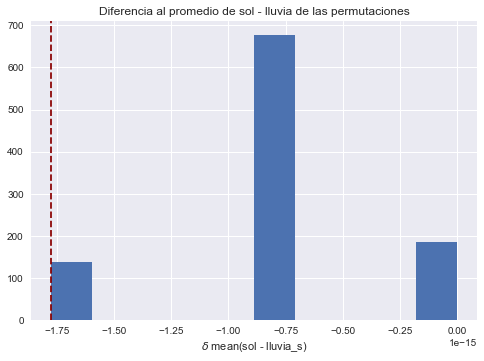

In [102]:
plt.hist(deltas - np.mean(deltas))
plt.axvline(delta_0 - np.mean(deltas), color='darkred', linestyle='--', label='valor muestra')
plt.title('Diferencia al promedio de sol - lluvia de las permutaciones')
plt.xlabel(r'$\delta$ mean(sol - lluvia_s)')

In [124]:
p = np.sum(abs(deltas) > abs(delta_0)) / 1000.
print('Probabilidad de el valor de la muestra en la distribución de permutaciones: {:.2f}'.format(p))

Probabilidad de el valor de la muestra en la distribución de permutaciones: 0.85


#### Pruebo lo mismo para datos que si están correlacionados

Da igual :(

In [135]:
x = np.random.normal(size=1000)
y = x + 100 + np.random.normal(scale=0.4, size=1000)

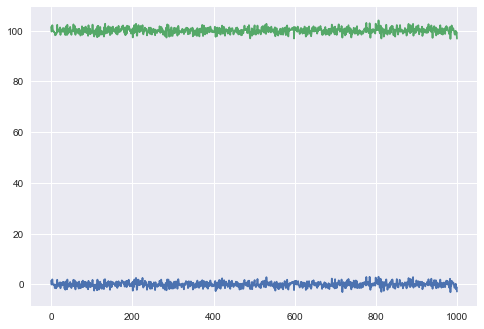

In [153]:
plt.plot(range(1000), x, range(1000), y)

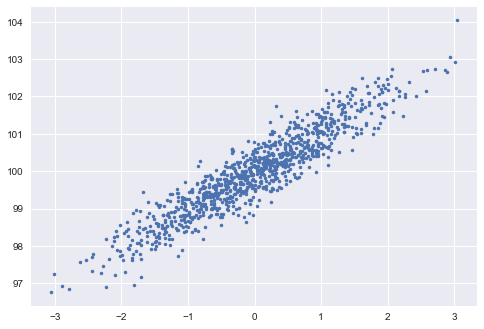

In [146]:
plt.plot(x, y, '.')

In [148]:
deltas = []
for i in range(1000):
    x_s = np.copy(x)
    np.random.shuffle(x_s)
    delta_1 = (x_s - y).mean()
    deltas.append(delta_1)
    
delta_0 = (x - y).mean()

In [149]:
deltas = np.array(deltas)

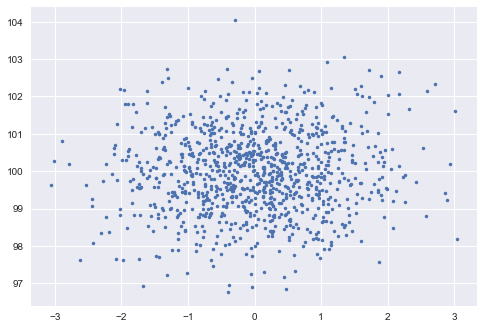

In [147]:
plt.plot(x_s, y, '.')

In [152]:
print(delta_0)
print(np.std(deltas))

-99.9879306194
2.83363160193e-14


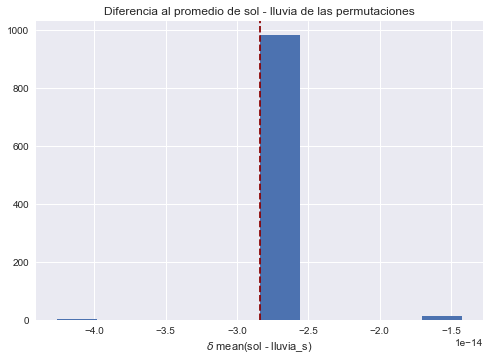

In [151]:
plt.hist(deltas - np.mean(deltas))
plt.axvline(delta_0 - np.mean(deltas), color='darkred', linestyle='--', label='valor muestra')
plt.title('Diferencia al promedio de sol - lluvia de las permutaciones')
plt.xlabel(r'$\delta$ mean(sol - lluvia_s)')